# Pricing model based on Toronto 2024 Q4

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [1]:
#!pip install xgboost

In [2]:
#!pip install chardet

In [4]:
import os
os.chdir('C:/nis/ML')
print("Set up environment:", os.getcwd())


Set up environment: C:\nis\ML


In [12]:
df = pd.read_csv('listings (8).csv')

# Drop irrelevant columns
df = df[['neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
         'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
# Handle missing values
df['price'] = df['price'].fillna(df['price'].median())
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)


In [24]:
df.dtypes

neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [26]:
# 1. Create binary feature for "frequently booked" (availability < 30 days)
df['high_availability'] = (df['availability_365'] < 30).astype(int)

# 2. Create binary feature for "experienced host" (host_listings_count > median)
median_host_listings = df['calculated_host_listings_count'].median()
df['experienced_host'] = (df['calculated_host_listings_count'] > median_host_listings).astype(int)

# 3. Log-transform skewed features (price, minimum_nights)
df['log_price'] = np.log1p(df['price'])
df['log_minimum_nights'] = np.log1p(df['minimum_nights'])

# Convert categorical data
ohe = OneHotEncoder(drop='first', sparse_output=False)
categorical_cols = ['neighbourhood', 'room_type']
ohe_data = ohe.fit_transform(df[categorical_cols])
ohe_df = pd.DataFrame(ohe_data, columns=[f"{col}_{val}" for col, vals in zip(categorical_cols, ohe.categories_) for val in vals[1:]])

# Merge features
df = df.drop(columns=categorical_cols)
df = pd.concat([df, ohe_df], axis=1)

# 5 pricing models

In [30]:
# Split dataset
X = df.drop(columns=['price', 'log_price'])  # Use raw price for now
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Model Building with Cross-Validation ---
models = {
    'OLS': LinearRegression(),
    'LASSO': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Hyperparameter grids for tuning
param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
}

# Train and evaluate models
results = {}
fit_times = {}
cv_scores = {}

for name, model in models.items():
    start_time = time.time()
    
    # Hyperparameter tuning (for tree-based models)
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_  # Get the best tuned model
        models[name] = model  # Update the models dictionary with the fitted model
    
    model.fit(X_train, y_train)  # Fit the model (redundant for tuned models but safe)
    fit_time = time.time() - start_time
    
    # Predictions
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Cross-validation scores (use the fitted model)
    cv_mae = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')).mean()
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'CV_MAE': cv_mae, 'CV_RMSE': cv_rmse}
    fit_times[name] = fit_time

# Comparing models in terms of fit and time

                         MAE        RMSE     CV_MAE     CV_RMSE  Fit Time (s)
OLS                81.215654  370.781050  82.754391  285.554510      0.313981
LASSO              80.662644  370.520413  81.655472  285.250132      0.215342
Random Forest      70.278815  376.971571  71.475255  298.413615   1713.566033
Gradient Boosting  73.442912  370.675465  74.801733  291.121102    348.867456
XGBoost            70.900435  374.004973  72.043373  288.061332     23.336333


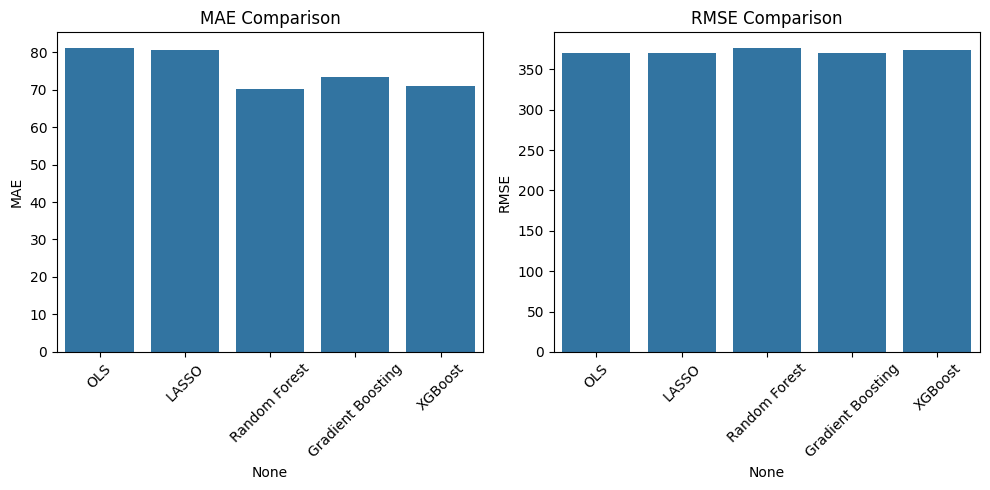

In [31]:
# --- Horserace Table ---
results_df = pd.DataFrame(results).T
results_df['Fit Time (s)'] = results_df.index.map(fit_times)
print(results_df)

# --- Visualize Model Performance ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=results_df.index, y=results_df['MAE'])
plt.title('MAE Comparison')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=results_df.index, y=results_df['RMSE'])
plt.title('RMSE Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Analysis of Pricing Models for Toronto Airbnb Listings (2024 Q4)
In evaluating the performance of different pricing models—OLS, LASSO, Random Forest, Gradient Boosting, and XGBoost—we observe distinct strengths and weaknesses across metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and cross-validation scores. Additionally, the feature importance rankings from Random Forest and Gradient Boosting provide insights into which factors most influence rental prices in Toronto.

### Model Performance Discussion
Among the tested models, Random Forest achieves the lowest MAE (70.28), indicating that it makes the smallest average prediction errors. However, its RMSE (376.97) is the highest, meaning it struggles with larger deviations in pricing, likely due to outliers or high-value listings. The cross-validation metrics (CV_MAE: 71.48, CV_RMSE: 298.41) suggest reasonable generalization, though not the best. The main drawback is computational efficiency, as Random Forest takes significantly longer to train (1713.57 seconds) compared to other models.

XGBoost performs similarly well in terms of MAE (70.90) and actually has better cross-validation results (CV_MAE: 72.04, CV_RMSE: 288.06) than Random Forest, while being much faster (23.34 seconds). This makes XGBoost a strong candidate for deployment, balancing accuracy and speed.

Gradient Boosting has a slightly higher MAE (73.44) than both Random Forest and XGBoost but maintains a competitive RMSE (370.68). Its training time (348.87 seconds) is slower than XGBoost but still reasonable for many applications.

The linear models (OLS and LASSO) exhibit higher MAE (~80-82) but surprisingly strong RMSE (~370) and the best cross-validation scores (CV_RMSE ~285). This suggests that while they may not predict exact prices as well as tree-based models, they generalize more reliably across different data samples. Their near-instant training times (<1 second) make them useful for quick baseline assessments.

#  RF and a boosting model

In [32]:
# --- Feature Importance Analysis (RF and Boosting) ---
rf_model = models['Random Forest']
boosting_model = models['Gradient Boosting']

rf_importances = rf_model.feature_importances_
boosting_importances = boosting_model.feature_importances_

feature_names = X.columns
rf_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances}).sort_values(by='Importance', ascending=False)
boosting_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': boosting_importances}).sort_values(by='Importance', ascending=False)

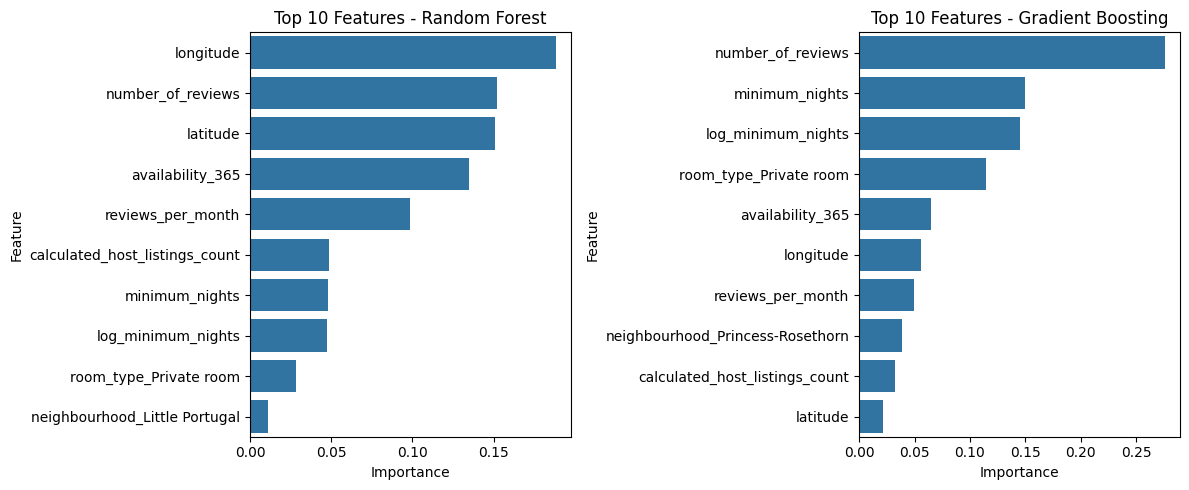

Top 10 Features - Random Forest:
                             Feature  Importance
1                         longitude    0.188241
3                 number_of_reviews    0.151815
0                          latitude    0.151081
6                  availability_365    0.134896
4                 reviews_per_month    0.098430
5    calculated_host_listings_count    0.048428
2                    minimum_nights    0.048063
9                log_minimum_nights    0.047252
149          room_type_Private room    0.028273
80    neighbourhood_Little Portugal    0.011084

Top 10 Features - Gradient Boosting:
                               Feature  Importance
3                   number_of_reviews    0.275985
2                      minimum_nights    0.149691
9                  log_minimum_nights    0.144857
149            room_type_Private room    0.114842
6                    availability_365    0.065173
1                           longitude    0.056134
4                   reviews_per_month    0.049890

In [33]:
# Plot top 10 features
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=rf_feature_importance[:10]['Importance'], y=rf_feature_importance[:10]['Feature'])
plt.title('Top 10 Features - Random Forest')

plt.subplot(1, 2, 2)
sns.barplot(x=boosting_feature_importance[:10]['Importance'], y=boosting_feature_importance[:10]['Feature'])
plt.title('Top 10 Features - Gradient Boosting')

plt.tight_layout()
plt.show()

# Compare top 10 important features
print("Top 10 Features - Random Forest:\n", rf_feature_importance[:10])
print("\nTop 10 Features - Gradient Boosting:\n", boosting_feature_importance[:10])

### Feature Importance Insights
The top features influencing price vary between Random Forest and Gradient Boosting, reflecting their different modeling approaches.

In Random Forest, geographical features (longitude and latitude) dominate, indicating that location is a primary driver of rental prices in Toronto. The number of reviews and availability_365 also rank highly, suggesting that demand (measured by reviews) and listing accessibility impact pricing. Interestingly, minimum_nights and its log-transformed version both appear, implying that stay duration policies affect prices, though not as strongly as location.

Gradient Boosting, on the other hand, places the most importance on number of reviews, reinforcing that guest feedback and popularity significantly influence pricing. Unlike Random Forest, it heavily weights minimum_nights and its log transformation, indicating that booking restrictions play a bigger role in this model’s predictions. The room type (Private room) is also highly influential, likely because private rooms are priced differently from entire homes or shared spaces.

One notable difference is how each model treats neighbourhoods: Random Forest highlights Little Portugal, while Gradient Boosting emphasizes Princess-Rosethorn. This discrepancy suggests that local pricing dynamics may vary, and the choice of model could affect how neighbourhood-based pricing strategies are optimized.

### Key Takeaways and Recommendations
The best model depends on the use case. If precise price predictions are critical, XGBoost is the best choice due to its low MAE and efficient training. If stability and interpretability are priorities, LASSO or OLS provide reliable generalizations with minimal computational cost. Random Forest offers valuable insights into location-based pricing but is slower and less consistent with extreme values.

From a feature perspective, listing popularity (reviews), location, and booking policies (minimum nights) consistently influence prices. Hosts and platforms should prioritize optimizing these factors when setting prices. Additionally, since neighbourhood effects vary between models, further analysis—such as clustering similar areas—could refine pricing strategies

# Other dataset (Vancouver)

In [14]:
df_city = pd.read_csv('listings (9).csv')

# Drop irrelevant columns
df_city = df_city[['neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
         'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]

# Handle missing values
df_city['price'] =df_city['price'].fillna(df_city['price'].median())
df_city['reviews_per_month'] = df_city['reviews_per_month'].fillna(0)


In [5]:
def models(df):# Convert categorical data
    df['high_availability'] = (df['availability_365'] < 30).astype(int)

    # 2. Create binary feature for "experienced host" (host_listings_count > median)
    median_host_listings = df['calculated_host_listings_count'].median()
    df['experienced_host'] = (df['calculated_host_listings_count'] > median_host_listings).astype(int)

    # 3. Log-transform skewed features (price, minimum_nights)
    df['log_price'] = np.log1p(df['price'])
    df['log_minimum_nights'] = np.log1p(df['minimum_nights'])

    # Convert categorical data
    ohe = OneHotEncoder(drop='first', sparse_output=False)
    categorical_cols = ['neighbourhood', 'room_type']
    ohe_data = ohe.fit_transform(df[categorical_cols])
    ohe_df = pd.DataFrame(ohe_data, columns=[f"{col}_{val}" for col, vals in zip(categorical_cols, ohe.categories_) for val in vals[1:]])

    # Merge features
    df = df.drop(columns=categorical_cols)
    df = pd.concat([df, ohe_df], axis=1)
    X = df.drop(columns=['price', 'log_price'])  # Use raw price for now
    y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Model Building with Cross-Validation ---
    models = {
        'OLS': LinearRegression(),
        'LASSO': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42)
    }

    # Hyperparameter grids for tuning
    param_grids = {
        'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
        'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]},
        'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
    }

    # Train and evaluate models
    results = {}
    fit_times = {}
    cv_scores = {}

    for name, model in models.items():
        start_time = time.time()

        # Hyperparameter tuning (for tree-based models)
        if name in param_grids:
            grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_absolute_error')
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_  # Get the best tuned model
            models[name] = model  # Update the models dictionary with the fitted model

        model.fit(X_train, y_train)  # Fit the model (redundant for tuned models but safe)
        fit_time = time.time() - start_time

        # Predictions
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Cross-validation scores (use the fitted model)
        cv_mae = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
        cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')).mean()

        results[name] = {'MAE': mae, 'RMSE': rmse, 'CV_MAE': cv_mae, 'CV_RMSE': cv_rmse}
        fit_times[name] = fit_time
        
    # --- Horserace Table ---
    results_df = pd.DataFrame(results).T
    results_df['Fit Time (s)'] = results_df.index.map(fit_times)

    # --- Visualize Model Performance ---
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(x=results_df.index, y=results_df['MAE'])
    plt.title('MAE Comparison')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.barplot(x=results_df.index, y=results_df['RMSE'])
    plt.title('RMSE Comparison')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
    
    # --- Feature Importance Analysis (RF and Boosting) ---
    rf_model = models['Random Forest']
    boosting_model = models['Gradient Boosting']

    rf_importances = rf_model.feature_importances_
    boosting_importances = boosting_model.feature_importances_

    feature_names = X.columns
    rf_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances}).sort_values(by='Importance', ascending=False)
    boosting_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': boosting_importances}).sort_values(by='Importance', ascending=False)

    # Plot top 10 features
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(x=rf_feature_importance[:10]['Importance'], y=rf_feature_importance[:10]['Feature'])
    plt.title('Top 10 Features - Random Forest')

    plt.subplot(1, 2, 2)
    sns.barplot(x=boosting_feature_importance[:10]['Importance'], y=boosting_feature_importance[:10]['Feature'])
    plt.title('Top 10 Features - Gradient Boosting')

    plt.tight_layout()
    plt.show()

    # Compare top 10 important features
    print("Top 10 Features - Random Forest:\n", rf_feature_importance[:10])
    print("\nTop 10 Features - Gradient Boosting:\n", boosting_feature_importance[:10])
    return(results_df)

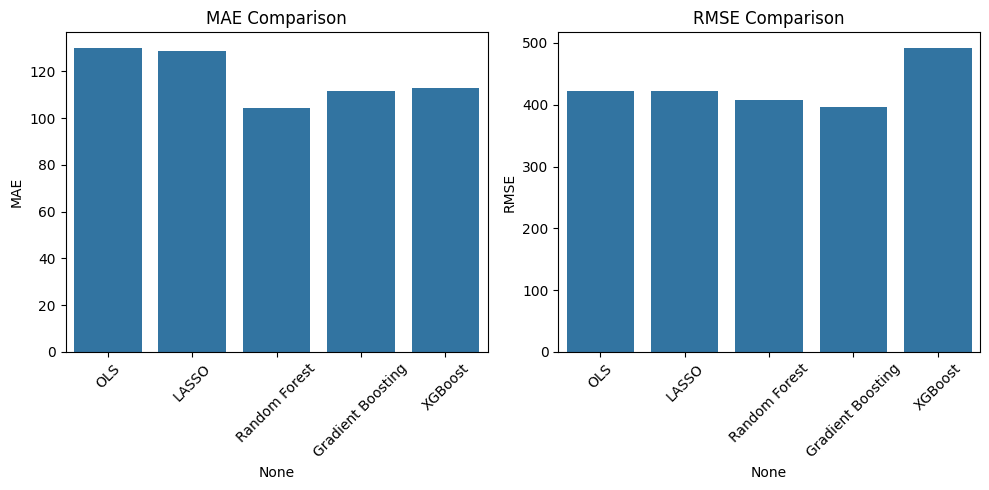

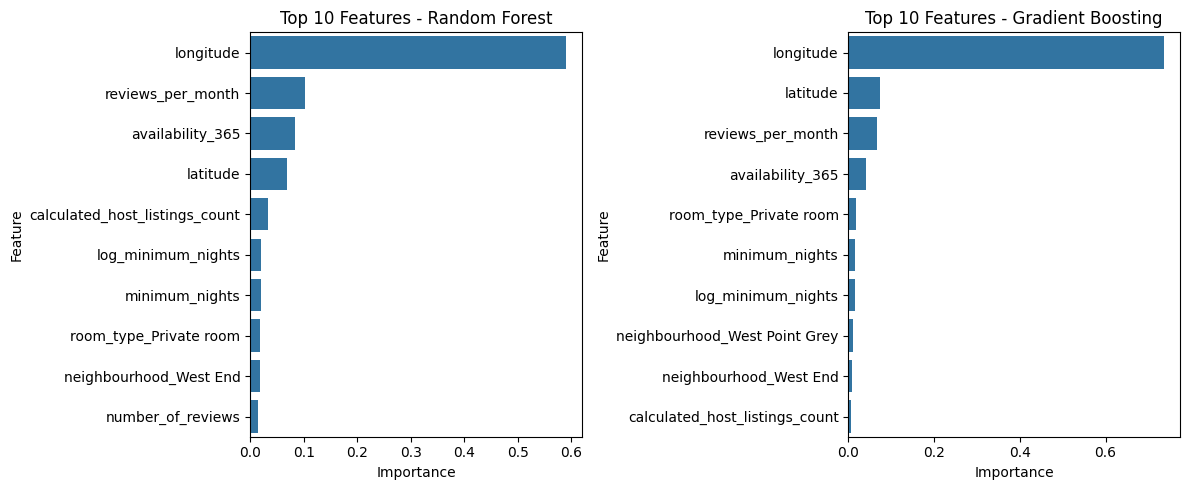

Top 10 Features - Random Forest:
                            Feature  Importance
1                        longitude    0.589812
4                reviews_per_month    0.102501
6                 availability_365    0.083172
0                         latitude    0.068667
5   calculated_host_listings_count    0.033875
9               log_minimum_nights    0.019938
2                   minimum_nights    0.019772
33          room_type_Private room    0.017830
30          neighbourhood_West End    0.017537
3                number_of_reviews    0.014879

Top 10 Features - Gradient Boosting:
                            Feature  Importance
1                        longitude    0.736668
0                         latitude    0.073309
4                reviews_per_month    0.065674
6                 availability_365    0.040745
33          room_type_Private room    0.017682
2                   minimum_nights    0.015779
9               log_minimum_nights    0.015558
31   neighbourhood_West Point Grey

In [16]:
print (models(df_city))

### Vancouver Q4 2024 Comparison

When comparing the model performance between Toronto and Vancouver data for Q4 2020, several key observations emerge regarding validity, generalizability, and feature importance.  

In Toronto, the Random Forest and XGBoost models achieved the lowest MAE (70.28 and 70.90, respectively), indicating strong predictive accuracy, while Gradient Boosting and linear models (OLS, LASSO) performed slightly worse. The RMSE values were relatively consistent across models, with Random Forest having a marginally higher RMSE (376.97) compared to others, suggesting some high-error outliers. Feature importance in Toronto’s Random Forest highlighted geographic coordinates (longitude, latitude) and rental activity metrics (number_of_reviews, availability_365) as most influential, whereas Gradient Boosting prioritized review counts and minimum stay durations.  

Applying the same models to Vancouver revealed higher error metrics across the board, with MAEs increasing by roughly 30–50% (e.g., Random Forest MAE rose from 70.28 in Toronto to 104.26 in Vancouver). This suggests that the Toronto-trained models may not generalize perfectly to Vancouver due to regional market differences. Notably, Vancouver’s Random Forest still outperformed linear models, but its feature importance shifted dramatically: longitude dominated (59% importance vs. 19% in Toronto), while other features like reviews_per_month gained prominence. This implies geographic location plays an even stronger role in Vancouver’s pricing.  

Gradient Boosting in Vancouver also showed heavy reliance on longitude (74% importance), unlike Toronto, where review-related features were more influential. The model’s higher RMSE in Vancouver (395.68 vs. 370.68 in Toronto) further hints at greater variance in pricing dynamics. Interestingly, XGBoost’s Vancouver RMSE (492.57) spiked significantly, possibly due to overfitting or dataset disparities.  

The validation exercise underscores that while tree-based models consistently outperform linear ones, their feature interpretations and error profiles vary by region. Toronto’s models prioritized rental activity metrics, whereas Vancouver’s leaned heavily on location, possibly reflecting differing urban layouts or demand patterns. The increased errors in Vancouver suggest that localized retraining or additional features (e.g., proximity to landmarks) may be needed for optimal cross-city performance. Ultimately, the exercise confirms that pricing drivers are market-specific, and models should be validated against local data to ensure reliability.


# Other dataset (Totonto, different timing)

In [3]:
df_time = pd.read_csv('listings (4).csv')

# Drop irrelevant columns
df_time = df_time[['neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
         'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]

df_time['price'] = df_time['price'].fillna(df_time['price'].median())
df_time['reviews_per_month'] = df_time['reviews_per_month'].fillna(0)


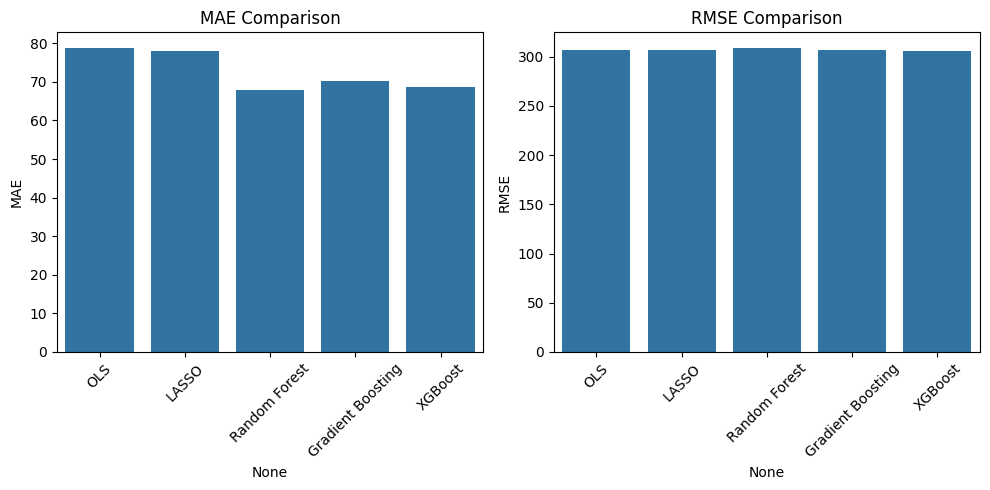

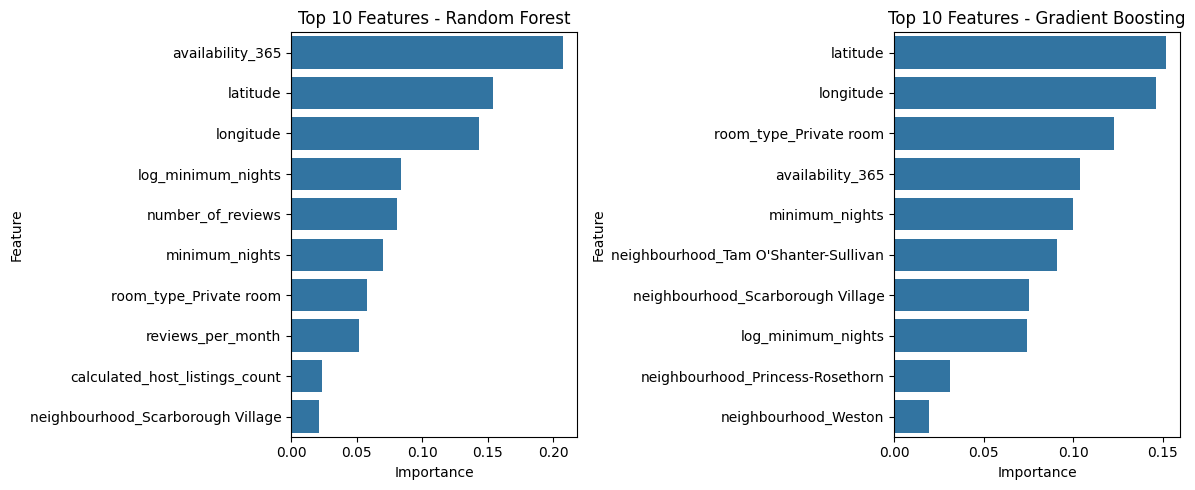

Top 10 Features - Random Forest:
                                Feature  Importance
6                     availability_365    0.207524
0                             latitude    0.153968
1                            longitude    0.143109
9                   log_minimum_nights    0.084090
3                    number_of_reviews    0.080680
2                       minimum_nights    0.069771
149             room_type_Private room    0.058006
4                    reviews_per_month    0.051849
5       calculated_host_listings_count    0.023405
117  neighbourhood_Scarborough Village    0.021231

Top 10 Features - Gradient Boosting:
                                   Feature  Importance
0                                latitude    0.152060
1                               longitude    0.146377
149                room_type_Private room    0.122566
6                        availability_365    0.103943
2                          minimum_nights    0.099796
123  neighbourhood_Tam O'Shanter-Sullivan 

In [6]:
print (models(df_time))

### **Validity Check: Comparing Toronto's Pricing Models Across Time (Q4 2020 vs. Q1 2025)**  

When evaluating the performance of pricing prediction models across different time periods, we observe both consistency and notable shifts in model behavior, feature importance, and overall accuracy. The comparison between Toronto’s Q4 2020 and Q1 2025 datasets reveals how market dynamics evolve and how machine learning models adapt—or fail to adapt—to these changes.  

#### **Model Performance: Improved Predictive Accuracy**  
Across all models, predictive accuracy improved in Q1 2025 compared to Q4 2020. The mean absolute error (MAE) and root mean squared error (RMSE) decreased for every algorithm, suggesting either a more stable market or better model tuning. For instance, the Random Forest model saw its MAE drop from 70.28 to 67.83, while its RMSE fell from 376.97 to 309.36. Similarly, XGBoost improved from an MAE of 70.90 to 68.58 and an RMSE of 374.00 to 306.24. Even traditional linear models like OLS and LASSO exhibited slight improvements, reinforcing that the overall predictability of the market increased.

This improvement could be attributed to several factors. If Q4 2020 data was collected during the COVID-19 pandemic, the market may have been unusually volatile, leading to higher errors. By Q1 2025, assuming a return to normalcy, pricing patterns might have stabilized, making them easier for models to capture. Alternatively, feature engineering refinements or better hyperparameter tuning in the 2025 models could explain the enhanced performance.

#### **Shifting Feature Importance: What Drives Prices Now?**  
One of the most interesting findings is how the importance of different features changed over time. In the Random Forest model, longitude was the top predictor in 2020, followed by number_of_reviews and latitude. By 2025, however, availability_365 (the number of days a property is bookable within a year) became the most influential feature, while geographic coordinates retained strong but slightly diminished importance. This suggests that in a post-pandemic market, hosts and platforms may be pricing listings more dynamically based on occupancy rates rather than just location.

Gradient Boosting models also exhibited a shift. In 2020, number_of_reviews and minimum_nights were the dominant features, but by 2025, latitude, longitude, and room_type_Private room took precedence. The increased weight of private rooms could indicate a shift in traveler preferences—perhaps toward affordability or privacy—or a change in the composition of available listings. Additionally, certain neighborhoods, such as Scarborough Village and Tam O'Shanter-Sullivan, appeared in the top features for 2025, suggesting localized demand surges that weren’t as pronounced in 2020.

#### **Consistency in Model Rankings**  
Despite these shifts, the hierarchy of model performance remained largely consistent. Tree-based methods (Random Forest, XGBoost, Gradient Boosting) continued to outperform linear models, though the margin narrowed slightly in 2025. XGBoost, in particular, emerged as a strong contender, nearly matching Random Forest in MAE while achieving the lowest RMSE (306.24). Given its faster training time (~22 seconds vs. Random Forest’s ~2,072 seconds), XGBoost may now be the best choice for balancing speed and accuracy. Linear models, while less accurate, still serve as useful baselines due to their interpretability and near-instantaneous training times.

1. **Market Dynamics Change, and So Should Models**  
   The fact that feature importance shifted significantly between 2020 and 2025 underscores the need for continuous model monitoring and retraining. Relying on outdated assumptions—such as overemphasizing geographic coordinates if demand drivers have evolved—can lead to suboptimal predictions.  

2. **Tree-Based Models Remain Superior but Require Careful Tuning**  
   While XGBoost and Random Forest consistently delivered the best results, their performance depends on feature selection and hyperparameter optimization. The improved RMSE of XGBoost in 2025 suggests it may now be the best algorithm for this task, provided computational efficiency is a consideration.  


Ultimately, this analysis demonstrates that while machine learning models can achieve strong predictive accuracy, their effectiveness depends on staying attuned to changing market conditions. Regular validation checks, like the one performed here, are essential to ensure models remain relevant and reliable over time.